# Import

In [1]:
# Basic
import pandas as pd
import numpy as np
import warnings

warnings.simplefilter('ignore')

# Preprocessing
from sklearn.preprocessing import *
from robusta.preprocessing import *
from dask_ml.preprocessing import *
from robusta.pipeline import *

# Eval
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score
from robusta.crossval import *

# Feature importance & selector
from robusta.importance import GroupPermutationImportance
from robusta.selector import *

# Data
from catboost.datasets import adult

# Model
from sklearn.linear_model import *
from lightgbm import LGBMRegressor, LGBMClassifier

# Plot
from jupyterthemes import jtplot
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

jtplot.style('gruvboxd')
matplotlib.use('nbagg')

Using TensorFlow backend.


# Data

In [2]:
TARGET = 'SalePrice'

train = pd.read_csv('./house/data/train.csv', index_col='Id')
test =  pd.read_csv('./house/data/test.csv',  index_col='Id')

y_train = train[TARGET]
train.drop(columns=TARGET, inplace=True)

train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal


# Feature Generating

In [3]:
prep_pipe = FeatureUnion([
    ("cat_freq", make_pipeline(
        TypeSelector("object"),
        SimpleImputer('mode'),
        Categorizer(),
        FrequencyEncoder(),
        ColumnGrouper('CatFreq'),
    )),
    ("cat_ohe", make_pipeline(
        TypeSelector("object"),
        SimpleImputer('mode'),
        Categorizer(),
        DummyEncoder(),
        ColumnGrouper('CatOHE'),
    )),
    ("cat_diff", make_pipeline(
        TypeSelector("object"),
        SimpleImputer('mode'),
        Categorizer(),
        BackwardDifferenceEncoder(),
        ColumnGrouper('CatDiff'),
    )),
    ("cat_poly", make_pipeline(
        TypeSelector("object"),
        SimpleImputer('mode'),
        Categorizer(),
        PolynomialEncoder(),
        ColumnGrouper('CatPoly'),
    )),
    ("cat_svd", make_pipeline(
        TypeSelector("object"),
        SimpleImputer('mode'),
        Categorizer(),
        SVDEncoder(),
        ColumnGrouper('CatSVD'),
    )),
    #("cat_bin", make_pipeline(
    #    TypeSelector("object"),
    #    SimpleImputer('mode'),
    #    BinaryEncoder(),
    #    ColumnGrouper('CatBin'),
    #)),
    #("cat_helm", make_pipeline(
    #    TypeSelector("object"),
    #    SimpleImputer('mode'),
    #    HashingEncoder(),
    #    ColumnGrouper('CatHelm'),
    #)),
    #("cat_sum", make_pipeline(
    #    TypeSelector("object"),
    #    SimpleImputer('mode'),
    #    SumEncoder(),
    #    ColumnGrouper('CatSum'),
    #)),
    #("cat_hash", make_pipeline(
    #    TypeSelector("object"),
    #    SimpleImputer('mode'),
    #    HashingEncoder(),
    #    ColumnGrouper('CatHash'),
    #)),
    #("num_std", make_pipeline(
    #    TypeSelector(np.number),
    #    StandardScaler(),
    #    SimpleImputer('mean'),
    #    ColumnGrouper('NumStd'),
    #)),
    ("num_rank", make_pipeline(
        TypeSelector(np.number),
        RankTransformer(),
        SimpleImputer('median'),
        ColumnGrouper('NumRank'),
    )),
    ("num_power", make_pipeline(
        TypeSelector(np.number),
        PandasTransformer(PowerTransformer()),
        SimpleImputer('median'),
        ColumnGrouper('NumPower'),
    )),
    ("num_minmax", make_pipeline(
        TypeSelector(np.number),
        MinMaxScaler(),
        SimpleImputer('mean'),
        ColumnGrouper('NumMinMax'),
    )),
    ("num_gr", make_pipeline(
        TypeSelector(np.number),
        GaussRankTransformer(),
        SimpleImputer('median'),
        ColumnGrouper('NumGR'),
    )),
])

X_train = prep_pipe.fit_transform(train)
X_test = prep_pipe.transform(test)

# Model

In [4]:
from sklearn.base import clone, BaseEstimator, RegressorMixin, ClassifierMixin


class MultiIndexRegressor(BaseEstimator, RegressorMixin):
    
    def __init__(self, regressor):
        self.regressor = regressor
        
    def fit(self, X, y, **fit_params):
        self.regressor_ = clone(self.regressor)
        self.regressor_.fit(X.values, y, **fit_params)
        return self
    
    def predict(self, X):
        return self.regressor_.predict(X.values)
    
    @property
    def feature_importances_(self):
        return self.regressor_.feature_importances_

    @property
    def coef_(self):
        return self.regressor_.coef_
    

class MultiIndexClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, classifier):
        self.classifier = classifier
        
    def fit(self, X, y, **fit_params):
        self.classifier_ = clone(self.classifier)
        self.classifier_.fit(X.values, y, **fit_params)
        return self
    
    def predict(self, X):
        return self.classifier_.predict(X.values)
    
    def predict_proba(self, X):
        return self.classifier_.predict_proba(X.values)
    
    @property
    def classes_(self):
        return self.classifier_.classes_


model = LGBMRegressor()
model = MultiIndexRegressor(model)
model = TransformedTargetRegressor(model, np.log1p, np.expm1)

# Task

In [5]:
from sklearn.metrics import mean_squared_log_error, mean_squared_error

scoring = lambda estimator, X, y: -mean_squared_log_error(y, estimator.predict(X))**0.5
cv = 5

# Baseline

In [8]:
# Full set
result = crossval(model, cv, X_train, y_train, X_new=X_test,
                  scoring=scoring, verbose=2, n_jobs=None)

[15:49:40]  MultiIndexRegressor

[15:49:42]  FOLD  0:   -0.1149
[15:49:44]  FOLD  1:   -0.1434
[15:49:46]  FOLD  2:   -0.1346
[15:49:48]  FOLD  3:   -0.1166
[15:49:50]  FOLD  4:   -0.1352

[15:49:50]  AVERAGE:   -0.1289 ± 0.0112



In [9]:
# Simple subset
features = ['NumGR', 'CatFreq']

result = crossval(model, cv, X_train[features], y_train, X_new=X_test[features],
                  scoring=scoring, verbose=2, n_jobs=None)

[15:49:50]  MultiIndexRegressor

[15:49:50]  FOLD  0:   -0.1211
[15:49:50]  FOLD  1:   -0.1473
[15:49:50]  FOLD  2:   -0.1386
[15:49:51]  FOLD  3:   -0.1215
[15:49:51]  FOLD  4:   -0.1357

[15:49:51]  AVERAGE:   -0.1328 ± 0.0102



# Group Permutation Importance

In [218]:
perm = GroupPermutationImportance(model, cv=cv, scoring=scoring, n_repeats=5, n_jobs=None)
perm.fit(X_train, y_train)

perm.feature_importances_

CatFreq      0.005381
CatOHE       0.009365
CatDiff      0.010108
CatPoly      0.022958
CatSVD       0.057484
NumRank      0.354825
NumPower     0.361934
NumMinMax    0.361542
NumGR        0.362983
dtype: float64

<IPython.core.display.Javascript object>


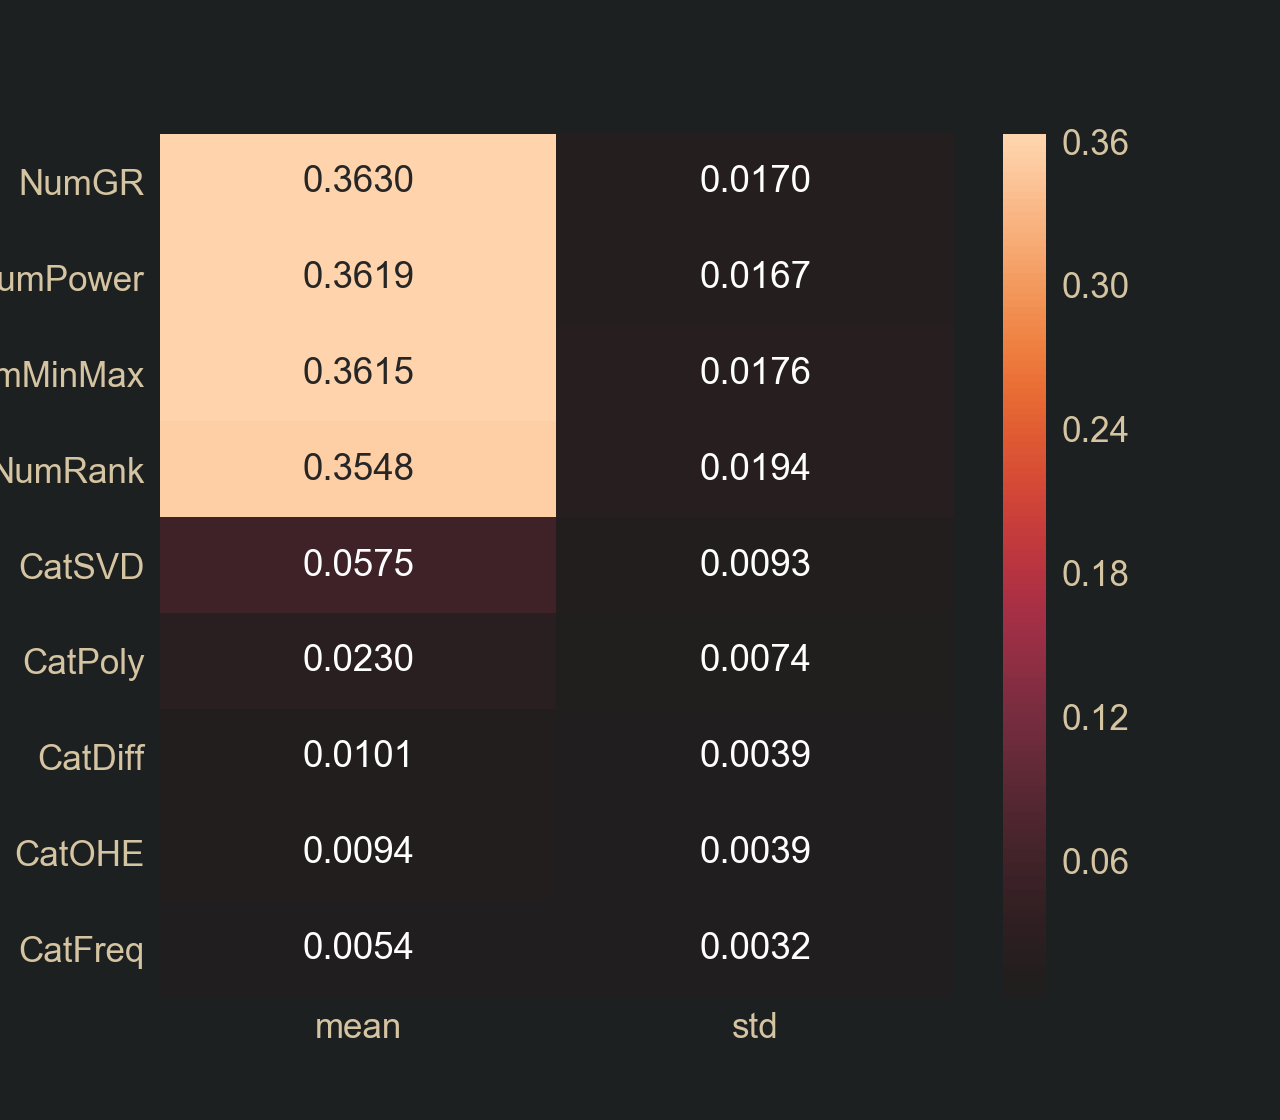

In [219]:
%matplotlib notebook

imp = pd.concat([perm.feature_importances_, perm.feature_importances_std_], axis=1)
imp.rename(columns={0: 'mean', 1: 'std'}, inplace=True)
imp.sort_values('mean', ascending=False, inplace=True)

sns.heatmap(imp, annot=True, fmt='0.4f', cmap='icefire', center=0)
plt.show()

# Group Permutation RFE

In [222]:
selector = GroupPermutationRFE(model, cv=cv, scoring=scoring, n_repeats=3,
                               min_features=1, verbose=2, n_jobs=None)
selector.fit(X_train, y_train)

[15:24:49] ITER: 1/9      SUBSET: 9/9      SCORE: -0.1289 ± 0.0112      ETA: 6 min 30 sec
[15:25:40] ITER: 2/9      SUBSET: 8/9      SCORE: -0.1290 ± 0.0112      ETA: 5 min 49 sec
[15:25:40]     – {'CatFreq'}
[15:26:29] ITER: 3/9      SUBSET: 7/9      SCORE: -0.1297 ± 0.0104      ETA: 4 min 58 sec
[15:26:29]     – {'NumGR'}
[15:27:14] ITER: 4/9      SUBSET: 6/9      SCORE: -0.1295 ± 0.0102      ETA: 4 min 2 sec
[15:27:14]     – {'CatOHE'}
[15:27:55] ITER: 5/9      SUBSET: 5/9      SCORE: -0.1297 ± 0.0105      ETA: 3 min 7 sec
[15:27:55]     – {'NumRank'}
[15:28:30] ITER: 6/9      SUBSET: 4/9      SCORE: -0.1291 ± 0.0098      ETA: 2 min 14 sec
[15:28:30]     – {'CatDiff'}
[15:29:04] ITER: 7/9      SUBSET: 3/9      SCORE: -0.1289 ± 0.0102      ETA: 1 min 26 sec
[15:29:04]     – {'NumMinMax'}
[15:29:35] ITER: 8/9      SUBSET: 2/9      SCORE: -0.1285 ± 0.0106      ETA: 41 sec
[15:29:35]     – {'CatPoly'}
[15:30:04] ITER: 9/9      SUBSET: 1/9      SCORE: -0.1834 ± 0.0090      ETA: 0 ms
[15:

GroupPermutationRFE(cv=5,
                    estimator=TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                                         inverse_func=<ufunc 'expm1'>,
                                                         regressor=MultiIndexRegressor(regressor=LGBMRegressor(boosting_type='gbdt',
                                                                                                               class_weight=None,
                                                                                                               colsample_bytree=1.0,
                                                                                                               importance_type='split',
                                                                                                               learning_rate=0.1,
                                                                                                               max_depth=-1,
                     

<IPython.core.display.Javascript object>


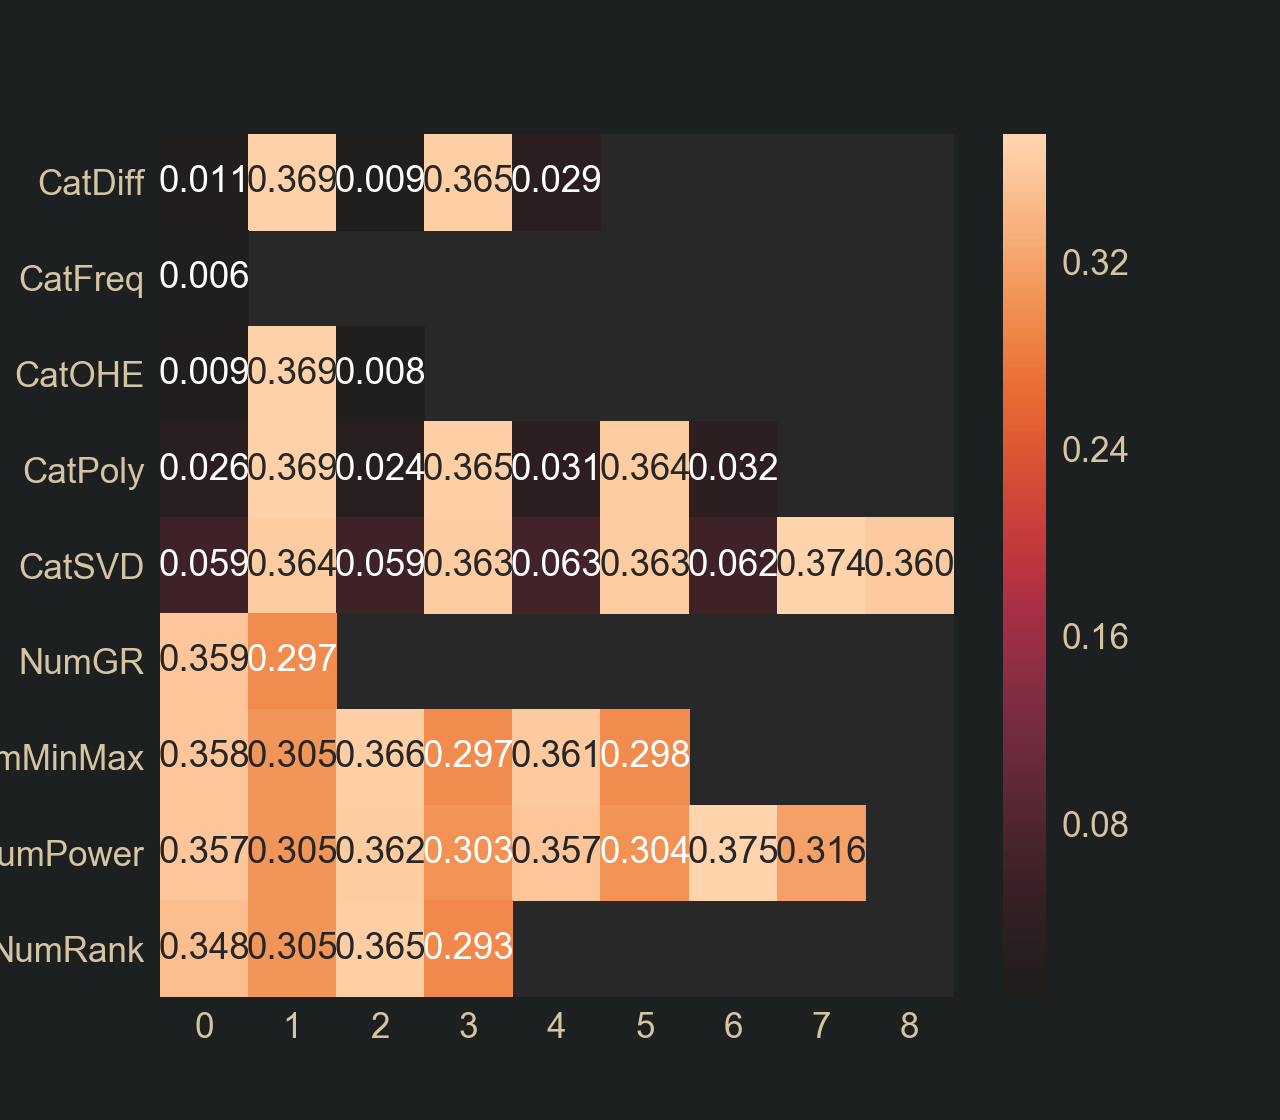

In [223]:
%matplotlib notebook

imps = pd.concat(list(selector.trials_['importance']), axis=1)

sns.heatmap(imps, annot=True, fmt='0.3f', cmap='icefire', center=0)
plt.show()

<IPython.core.display.Javascript object>


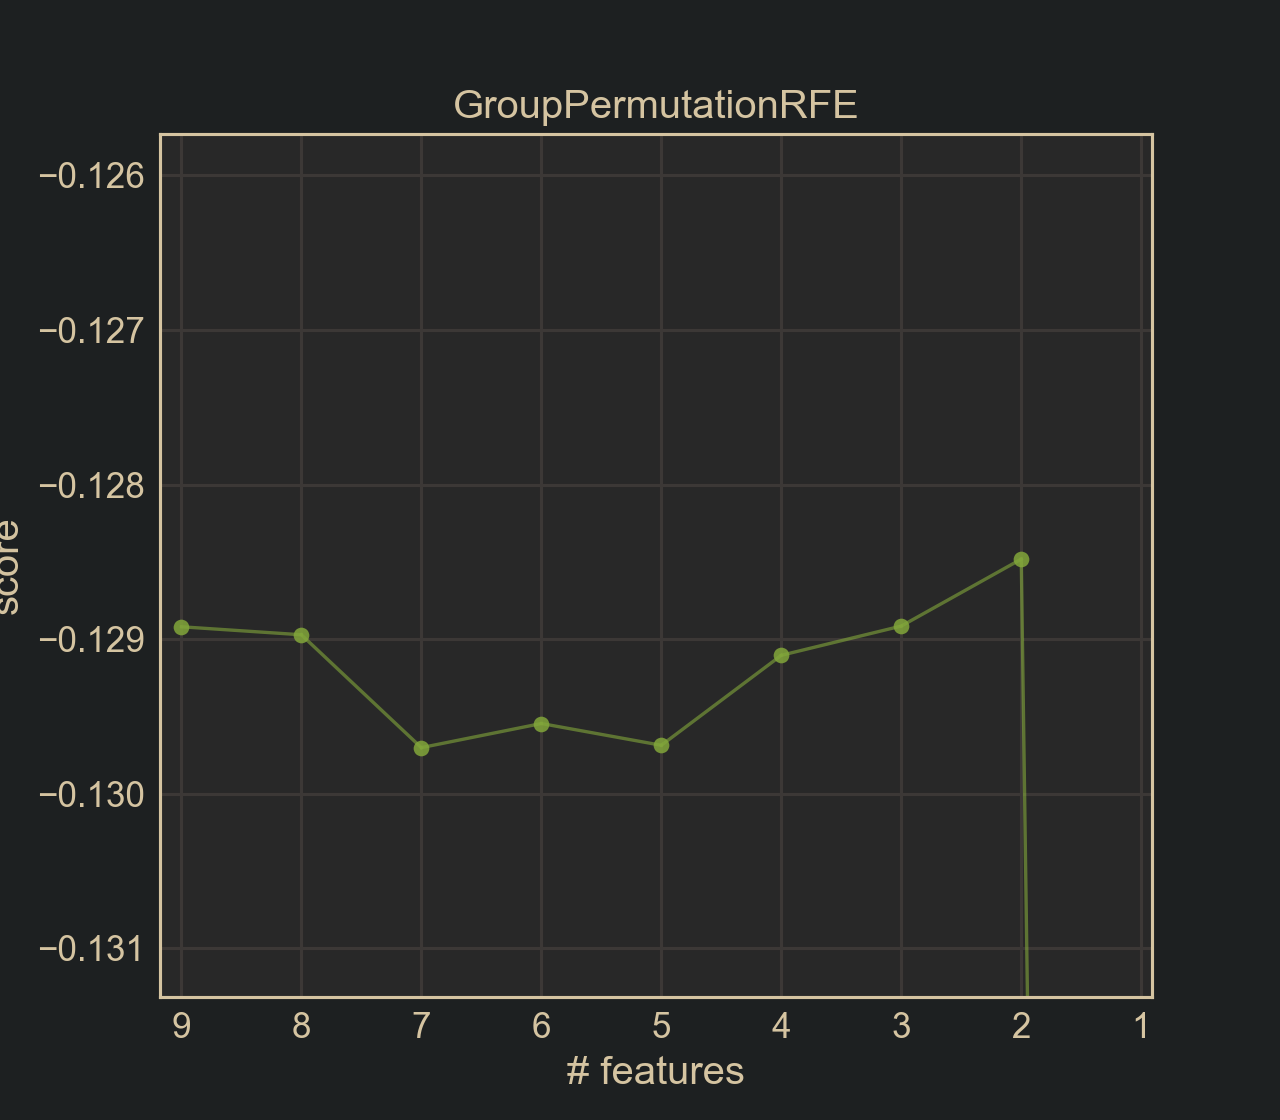

In [228]:
%matplotlib notebook

selector.plot(marker='o')

In [225]:
features = selector.get_features()
model = MultiIndexRegressor(LGBMRegressor())
model = TransformedTargetRegressor(model, np.log1p, np.expm1)

result = crossval(model, cv, X_train[features], y_train, X_new=X_test[features],
                  scoring=scoring, verbose=2, n_jobs=-1)

[15:30:36]  MultiIndexRegressor

[15:30:41]  FOLD  0:   -0.1157
[15:30:41]  FOLD  1:   -0.1412
[15:30:41]  FOLD  2:   -0.1358
[15:30:41]  FOLD  3:   -0.1161
[15:30:41]  FOLD  4:   -0.1338

[15:30:41]  AVERAGE:   -0.1285 ± 0.0106



# Group Random Selector

In [13]:
selector = GroupRandomSelector(model, cv=cv, scoring=scoring, max_iter=20,
                               min_features=1, max_features=5,
                               verbose=2, n_jobs=None)
selector.fit(X_train, y_train)

[15:03:57] ITER: 1/20      SUBSET: 3/9      SCORE: -0.1313 ± 0.0090      ETA: 25 sec
[15:03:59] ITER: 2/20      SUBSET: 4/9      SCORE: -0.1288 ± 0.0107      ETA: 30 sec
[15:04:06] ITER: 3/20      SUBSET: 4/9      SCORE: -0.1282 ± 0.0104      ETA: 56 sec
[15:04:12] ITER: 4/20      SUBSET: 4/9      SCORE: -0.1282 ± 0.0092      ETA: 1 min 5 sec
[15:04:14] ITER: 5/20      SUBSET: 3/9      SCORE: -0.1321 ± 0.0091      ETA: 53 sec
[15:04:15] ITER: 6/20      SUBSET: 4/9      SCORE: -0.1303 ± 0.0094      ETA: 45 sec
[15:04:16] ITER: 7/20      SUBSET: 1/9      SCORE: -0.1999 ± 0.0115      ETA: 37 sec
[15:04:23] ITER: 8/20      SUBSET: 3/9      SCORE: -0.1823 ± 0.0096      ETA: 40 sec
[15:04:24] ITER: 9/20      SUBSET: 1/9      SCORE: -0.1378 ± 0.0076      ETA: 33 sec
[15:04:25] ITER: 10/20      SUBSET: 4/9      SCORE: -0.1309 ± 0.0085      ETA: 29 sec
[15:04:27] ITER: 11/20      SUBSET: 3/9      SCORE: -0.1383 ± 0.0089      ETA: 25 sec
[15:04:34] ITER: 12/20      SUBSET: 5/9      SCORE: -0.130

GroupRandomSelector(cv=5,
                    estimator=TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                                         inverse_func=<ufunc 'expm1'>,
                                                         regressor=MultiIndexRegressor(regressor=LGBMRegressor(boosting_type='gbdt',
                                                                                                               class_weight=None,
                                                                                                               colsample_bytree=1.0,
                                                                                                               importance_type='split',
                                                                                                               learning_rate=0.1,
                                                                                                               max_depth=-1,
                     

<IPython.core.display.Javascript object>


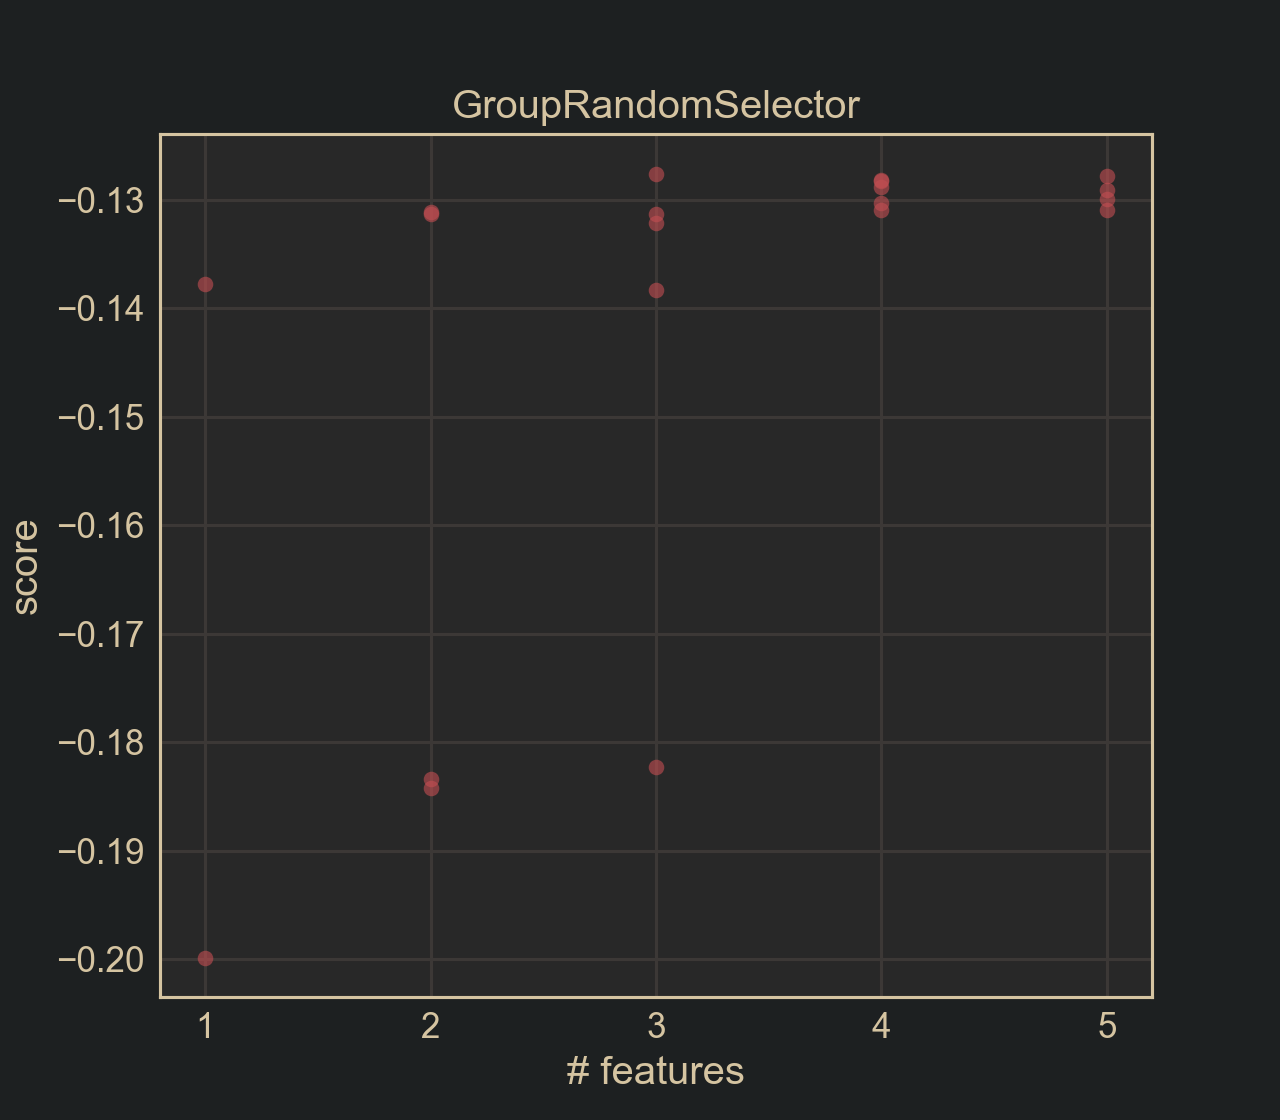

In [14]:
%matplotlib notebook

selector.plot(marker='o', color='r')

In [15]:
features = selector.get_features()

model = LGBMRegressor()
model = MultiIndexRegressor(model)
model = TransformedTargetRegressor(model, np.log1p, np.expm1)

result = crossval(model, cv, X_train[features], y_train, X_new=X_test[features],
                  scoring=scoring, verbose=2, n_jobs=-1)

[15:05:18]  MultiIndexRegressor

[15:05:24]  FOLD  0:   -0.1155
[15:05:24]  FOLD  1:   -0.1405
[15:05:24]  FOLD  2:   -0.1343
[15:05:24]  FOLD  3:   -0.1161
[15:05:24]  FOLD  4:   -0.1312

[15:05:24]  AVERAGE:   -0.1275 ± 0.0100



# Group Exhaustive Selector
### (Brute-force)

In [12]:
selector = GroupExhaustiveSelector(model, cv=cv, scoring=scoring,
                                   min_features=1, max_features=3,
                                   verbose=2, n_jobs=None)
selector.fit(X_train, y_train)

[15:51:49] ITER: 1/129      SUBSET: 1/9      SCORE: -0.1950 ± 0.0105      ETA: 56 sec
[15:51:49] ITER: 2/129      SUBSET: 1/9      SCORE: -0.1899 ± 0.0139      ETA: 1 min 11 sec
[15:51:50] ITER: 3/129      SUBSET: 1/9      SCORE: -0.1999 ± 0.0115      ETA: 1 min 17 sec
[15:51:51] ITER: 4/129      SUBSET: 1/9      SCORE: -0.1814 ± 0.0087      ETA: 1 min 27 sec
[15:51:57] ITER: 5/129      SUBSET: 1/9      SCORE: -0.1834 ± 0.0090      ETA: 3 min 27 sec
[15:51:58] ITER: 6/129      SUBSET: 1/9      SCORE: -0.1378 ± 0.0076      ETA: 3 min 10 sec
[15:51:59] ITER: 7/129      SUBSET: 1/9      SCORE: -0.1386 ± 0.0092      ETA: 2 min 58 sec
[15:52:00] ITER: 8/129      SUBSET: 1/9      SCORE: -0.1371 ± 0.0091      ETA: 2 min 48 sec
[15:52:00] ITER: 9/129      SUBSET: 1/9      SCORE: -0.1392 ± 0.0099      ETA: 2 min 39 sec
[15:52:01] ITER: 10/129      SUBSET: 2/9      SCORE: -0.1899 ± 0.0112      ETA: 2 min 30 sec
[15:52:02] ITER: 11/129      SUBSET: 2/9      SCORE: -0.1904 ± 0.0114      ETA: 2 min

[15:55:44] ITER: 88/129      SUBSET: 3/9      SCORE: -0.1276 ± 0.0101      ETA: 1 min 48 sec
[15:55:45] ITER: 89/129      SUBSET: 3/9      SCORE: -0.1304 ± 0.0089      ETA: 1 min 45 sec
[15:55:47] ITER: 90/129      SUBSET: 3/9      SCORE: -0.1314 ± 0.0083      ETA: 1 min 42 sec
[15:55:49] ITER: 91/129      SUBSET: 3/9      SCORE: -0.1302 ± 0.0083      ETA: 1 min 39 sec
[15:55:51] ITER: 92/129      SUBSET: 3/9      SCORE: -0.1317 ± 0.0091      ETA: 1 min 36 sec
[15:55:52] ITER: 93/129      SUBSET: 3/9      SCORE: -0.1309 ± 0.0094      ETA: 1 min 33 sec
[15:55:54] ITER: 94/129      SUBSET: 3/9      SCORE: -0.1313 ± 0.0085      ETA: 1 min 30 sec
[15:56:01] ITER: 95/129      SUBSET: 3/9      SCORE: -0.1822 ± 0.0112      ETA: 1 min 29 sec
[15:56:03] ITER: 96/129      SUBSET: 3/9      SCORE: -0.1297 ± 0.0104      ETA: 1 min 26 sec
[15:56:04] ITER: 97/129      SUBSET: 3/9      SCORE: -0.1284 ± 0.0106      ETA: 1 min 23 sec
[15:56:06] ITER: 98/129      SUBSET: 3/9      SCORE: -0.1297 ± 0.0100 

GroupExhaustiveSelector(cv=5,
                        estimator=TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                                             inverse_func=<ufunc 'expm1'>,
                                                             regressor=MultiIndexRegressor(regressor=LGBMRegressor(boosting_type='gbdt',
                                                                                                                   class_weight=None,
                                                                                                                   colsample_bytree=1.0,
                                                                                                                   importance_type='split',
                                                                                                                   learning_rate=0.1,
                                                                                                                  

<IPython.core.display.Javascript object>


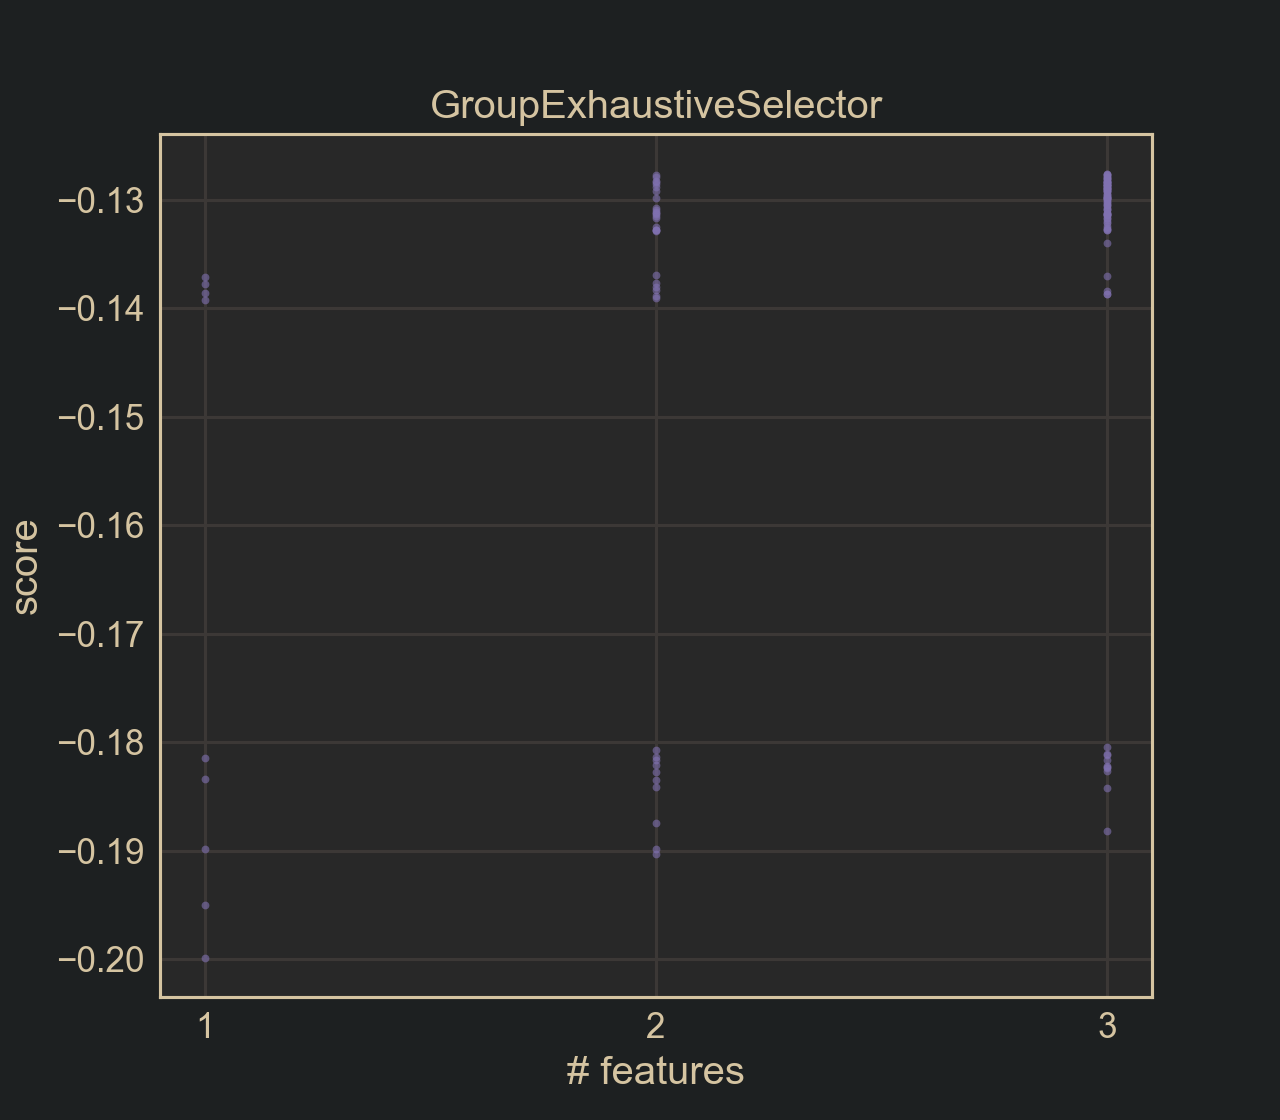

In [17]:
%matplotlib notebook

selector.plot(color='m')

In [16]:
features = selector.get_features()

result = crossval(model, cv, X_train[features], y_train, X_new=X_test[features],
                  scoring=scoring, verbose=2, n_jobs=-1)

[15:59:57]  MultiIndexRegressor

[16:00:02]  FOLD  0:   -0.1155
[16:00:02]  FOLD  1:   -0.1407
[16:00:02]  FOLD  2:   -0.1343
[16:00:02]  FOLD  3:   -0.1163
[16:00:02]  FOLD  4:   -0.1312

[16:00:02]  AVERAGE:   -0.1276 ± 0.0100



# Group Greed Selector

## Forward

In [6]:
selector = GroupGreedSelector(model, cv=cv, scoring=scoring, k_features=5, 
                              forward=True, floating=True,
                              verbose=2, n_jobs=None)
selector.fit(X_train, y_train)

[16:47:30] STEP FORWARD
[16:47:31] ITER: 1      SUBSET: 1/9      SCORE: -0.1999 ± 0.0115
[16:47:31]     + {'CatDiff'}
[16:47:32] ITER: 2      SUBSET: 1/9      SCORE: -0.1371 ± 0.0091
[16:47:32]     + {'NumMinMax'}
[16:47:33] ITER: 3      SUBSET: 1/9      SCORE: -0.1392 ± 0.0099
[16:47:33]     + {'NumGR'}
[16:47:38] ITER: 4      SUBSET: 1/9      SCORE: -0.1834 ± 0.0090
[16:47:38]     + {'CatSVD'}
[16:47:39] ITER: 5      SUBSET: 1/9      SCORE: -0.1899 ± 0.0139
[16:47:39]     + {'CatOHE'}
[16:47:39] ITER: 6      SUBSET: 1/9      SCORE: -0.1814 ± 0.0087
[16:47:39]     + {'CatPoly'}
[16:47:40] ITER: 7      SUBSET: 1/9      SCORE: -0.1378 ± 0.0076
[16:47:40]     + {'NumRank'}
[16:47:41] ITER: 8      SUBSET: 1/9      SCORE: -0.1386 ± 0.0092
[16:47:41]     + {'NumPower'}
[16:47:42] ITER: 9      SUBSET: 1/9      SCORE: -0.1950 ± 0.0105
[16:47:42]     + {'CatFreq'}
[16:47:42] STEP FORWARD
[16:47:43] ITER: 10      SUBSET: 2/9      SCORE: -0.1328 ± 0.0099
[16:47:43]     + {'CatDiff'}
[16:47:44] I

GroupGreedSelector(cv=5,
                   estimator=TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                                        inverse_func=<ufunc 'expm1'>,
                                                        regressor=MultiIndexRegressor(regressor=LGBMRegressor(boosting_type='gbdt',
                                                                                                              class_weight=None,
                                                                                                              colsample_bytree=1.0,
                                                                                                              importance_type='split',
                                                                                                              learning_rate=0.1,
                                                                                                              max_depth=-1,
                              

<IPython.core.display.Javascript object>


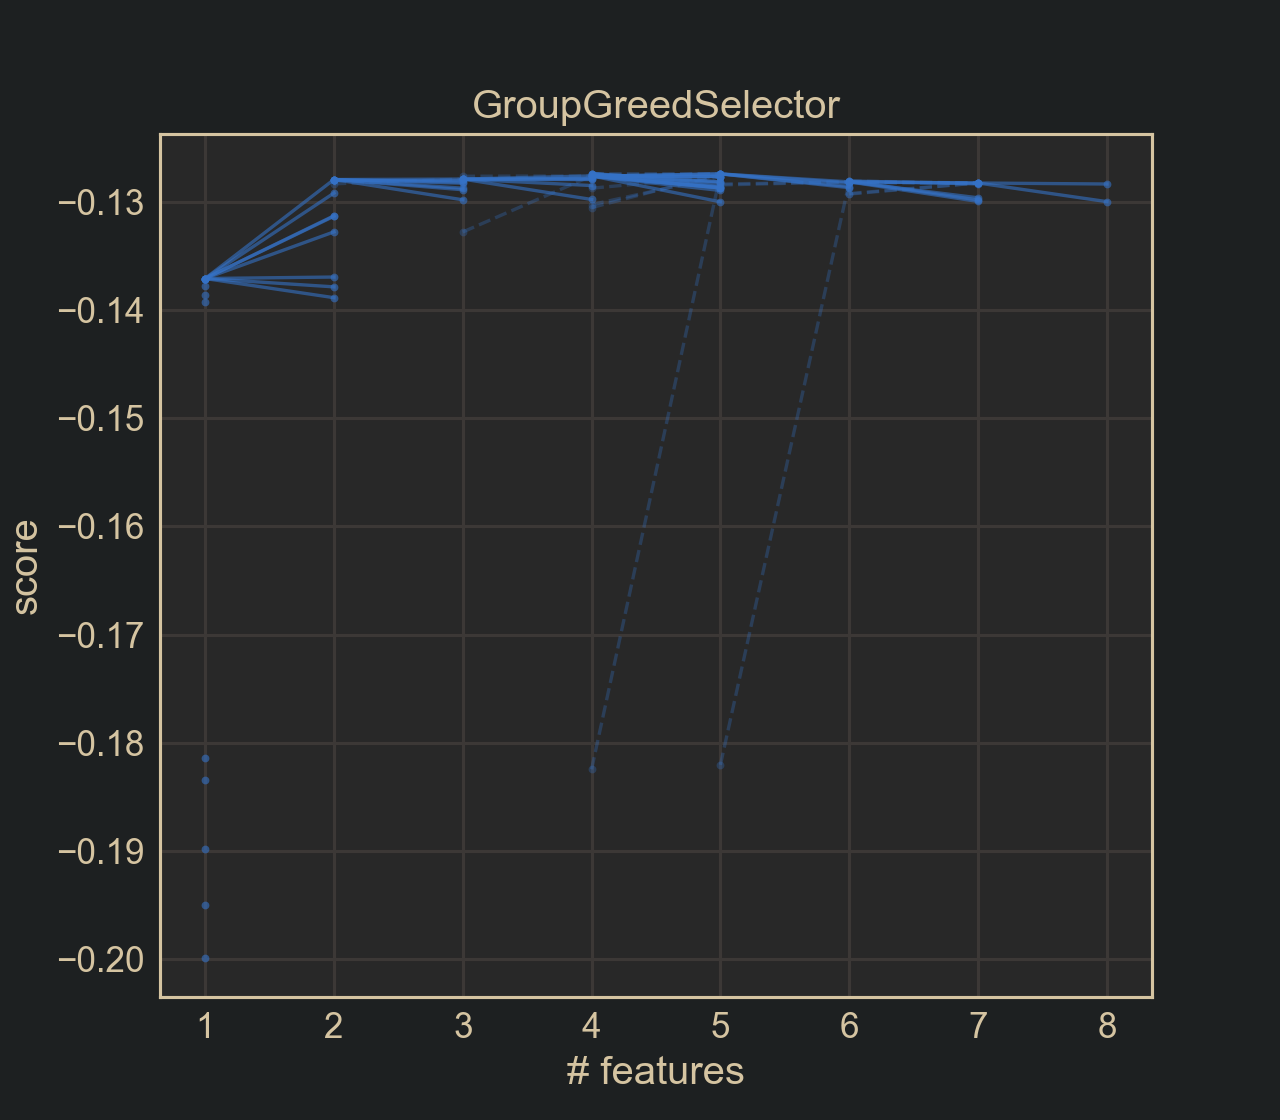

In [7]:
%matplotlib notebook

selector.plot(color='b')

In [8]:
features = selector.get_features()

result = crossval(model, cv, X_train[features], y_train, X_new=X_test[features],
                  scoring=scoring, verbose=2, n_jobs=-1)

[16:55:53]  MultiIndexRegressor

[16:55:58]  FOLD  0:   -0.1151
[16:55:58]  FOLD  1:   -0.1383
[16:55:58]  FOLD  2:   -0.1330
[16:55:58]  FOLD  3:   -0.1152
[16:55:58]  FOLD  4:   -0.1352

[16:55:59]  AVERAGE:   -0.1274 ± 0.0101



## Backward

In [10]:
selector = GroupGreedSelector(model, cv=cv, scoring=scoring, k_features=2, 
                              forward=False, floating=False,
                              verbose=2, n_jobs=None)
selector.fit(X_train, y_train)

[16:59:45] ITER: 1      SUBSET: 9/9      SCORE: -0.1291 ± 0.0110
[16:59:45] STEP BACKWARD
[16:59:54] ITER: 2      SUBSET: 8/9      SCORE: -0.1290 ± 0.0109
[16:59:54]     – {'CatDiff'}
[17:00:02] ITER: 3      SUBSET: 8/9      SCORE: -0.1283 ± 0.0109
[17:00:02]     – {'NumMinMax'}
[17:00:10] ITER: 4      SUBSET: 8/9      SCORE: -0.1297 ± 0.0103
[17:00:10]     – {'NumGR'}
[17:00:13] ITER: 5      SUBSET: 8/9      SCORE: -0.1288 ± 0.0101
[17:00:13]     – {'CatSVD'}
[17:00:22] ITER: 6      SUBSET: 8/9      SCORE: -0.1291 ± 0.0110
[17:00:22]     – {'CatOHE'}
[17:00:30] ITER: 7      SUBSET: 8/9      SCORE: -0.1288 ± 0.0103
[17:00:30]     – {'CatPoly'}
[17:00:38] ITER: 8      SUBSET: 8/9      SCORE: -0.1291 ± 0.0110
[17:00:38]     – {'NumRank'}
[17:00:46] ITER: 9      SUBSET: 8/9      SCORE: -0.1299 ± 0.0103
[17:00:46]     – {'NumPower'}
[17:00:55] ITER: 10      SUBSET: 8/9      SCORE: -0.1291 ± 0.0110
[17:00:55]     – {'CatFreq'}
[17:00:55] STEP BACKWARD
[17:01:03] ITER: 11      SUBSET: 7/9   

GroupGreedSelector(cv=5,
                   estimator=TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                                        inverse_func=<ufunc 'expm1'>,
                                                        regressor=MultiIndexRegressor(regressor=LGBMRegressor(boosting_type='gbdt',
                                                                                                              class_weight=None,
                                                                                                              colsample_bytree=1.0,
                                                                                                              importance_type='split',
                                                                                                              learning_rate=0.1,
                                                                                                              max_depth=-1,
                              

<IPython.core.display.Javascript object>


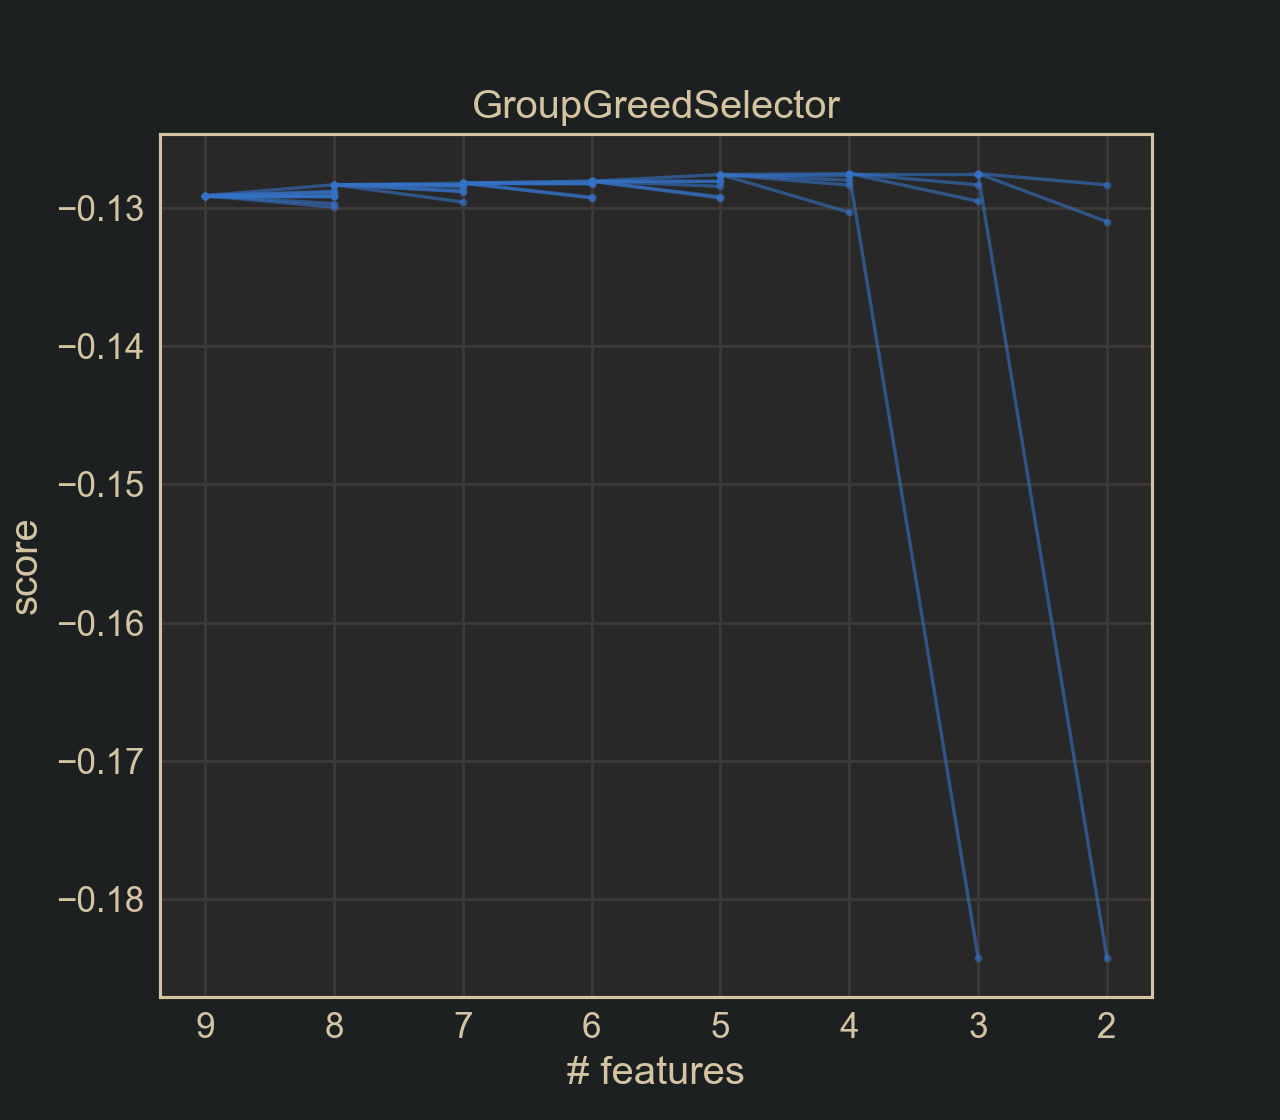

In [13]:
%matplotlib notebook

selector.plot(color='b')

In [14]:
features = selector.get_features()

result = crossval(model, cv, X_train[features], y_train, X_new=X_test[features],
                  scoring=scoring, verbose=2, n_jobs=-1)

[17:06:20]  MultiIndexRegressor

[17:06:25]  FOLD  0:   -0.1155
[17:06:25]  FOLD  1:   -0.1405
[17:06:25]  FOLD  2:   -0.1343
[17:06:25]  FOLD  3:   -0.1161
[17:06:25]  FOLD  4:   -0.1312

[17:06:25]  AVERAGE:   -0.1275 ± 0.0100

